# Capstone EDA

## Problem statement, goals and success criteria

In the 1940s, Lego created the first plastic brick that allows children and adults to create models that previously can only exist in their minds. Since then Lego has expanded and developed many different lines and variations of the plastic bricks to provide more and better choice that suit different customers. It would be interesting for both retailers and hobbyist to find out what factors drive the price of Lego sets. It would also be useful for them to understand what might cause a Lego set to be desirable and collectable which in other words is a good investment. 

There are two major goals for this project. The first is to use various data and features to predict the price of a Lego set. It is also important to determine the accuracy and methods for such determination. This is because one can utilise either regression techniques or classification technique. The second goal would be to successfully come up with a metric to measure how collectable a Lego set is and be able to, again using the available data, predict which Lego sets are desirable for collectors.

The success criteria for the project regarding to the first goal is to be able to
- predict price of a Lego set within 15% of its manufacturer suggested retail price (MSRP)
The success criteria for the project regarding to the second goal is to be able to
- define a metric to measure how desirable a Lego set is
- be able to classify Lego sets into more desirable/less desirable and beating the baseline accuracy (which depends on the definition of the metric)


## Proposed methods

Since the combined data set can be of a large size, feature selection is very important. The followings are possible approach to select the best features for the analysis

- Use sklearn RFECV to select features as a top down approach
- Examine the correlation coefficient to pick features for predictions
- Randomly pick features (Although this is not the best approach for a single regression model, it could be effective if an ensemble method is used) 
- Carry Out a Principal Component Analysis and depends on the result choose a subset of principal components as prediction features
- Use regularised methods in predictions (especially l1 regularisation when features can be eliminated).


Since the feature space is large and complicated, we do not know which prediction methods would better suit the analysis. Therefore it is proposed that various methods should be tried and evaluated. For price predictions, these includes (but not limited to):
- Linear regression (and it's regualrised counterparts i.e. Lasso and Ridge)
- Polynomial regression
- kNN regressor
- Decision Tree regressor (and depends on the result, more investigations on the use of ensemble trees regressors could be possible)

For the classification of desirable lego sets:
- kNN classifier
- Logistic regression classifier
- Linear Discriminant Analysis
- Support Vector Machine classifier
- Decision Tree classifier and its ensemble counterparts (e.g. Random Forest, Extra Trees and various boosting methods)

The metrics for regression analysis would be the Mean Squared Error. The metrics for classification would be its prediction accuracy.

## Cleaning of the Lego dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from __future__ import division
%matplotlib inline

In [3]:
engine = create_engine('postgresql://localhost/capstone')
lego = pd.read_sql('SELECT * FROM lego', engine)
lego.head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,GBP_MSRP,USD_MSRP,CAD_MSRP,EUR_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id
0,10246,Detective's Office,2015,Advanced Models,Modular Buildings,2262.0,6.0,http://images.brickset.com/sets/images/10246-1...,132.99,159.99,199.99,149.99,Box,Retail - limited,5008,10155,4.75,Model making,4,10246-1
1,10247,Ferris Wheel,2015,Advanced Models,Fairground,2464.0,10.0,http://images.brickset.com/sets/images/10247-1...,149.99,199.99,229.99,179.99,Box,Retail - limited,3219,4807,5,Model making,3,10247-1
2,10248,Ferrari F40,2015,Advanced Models,Vehicles,1158.0,NaN,http://images.brickset.com/sets/images/10248-1...,69.99,99.99,119.99,89.99,Box,LEGO exclusive,2030,3943,5,Model making,4,10248-1
3,10249,Toy Shop,2015,Advanced Models,Winter Village,898.0,NaN,http://images.brickset.com/sets/images/10249-1...,59.99,79.99,99.99,69.99,Box,LEGO exclusive,2046,4794,4,Model making,1,10249-1
4,10581,Ducks,2015,Duplo,Forest Animals,13.0,1.0,http://images.brickset.com/sets/images/10581-1...,9.99,9.99,12.99,9.99,Box,Retail,117,444,0,Pre-school,0,10581-1


In [3]:
lego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 20 columns):
Item_Number     6172 non-null object
Name            6172 non-null object
Year            6172 non-null int64
Theme           6172 non-null object
Subtheme        3966 non-null object
Pieces          6060 non-null float64
Minifigures     3500 non-null float64
Image_URL       6172 non-null object
GBP_MSRP        4215 non-null object
USD_MSRP        5800 non-null object
CAD_MSRP        1987 non-null object
EUR_MSRP        1800 non-null object
Packaging       6172 non-null object
Availability    6172 non-null object
wanted          6172 non-null object
owned           6172 non-null object
rating          6172 non-null object
theme_grp       6172 non-null object
review_num      6172 non-null object
query_id        6172 non-null object
dtypes: float64(2), int64(1), object(17)
memory usage: 964.4+ KB


Also mentioned in the previous part of gathering data, it is apparent that the lego data frame has got quite a few missing values. Therefore the upcoming procedures will try to clean the data and make it ready for analysis.

### Subtheme

Lego sets can have more than 1 theme and this is denoted in the Subtheme column. However not everyset has a subtheme which is reflected in the data. However it would make analysis difficult if they are left to be 'NaN's hence they will be filled with the string 'No_Subtheme'.

In [4]:
lego.Subtheme = lego.Subtheme.fillna('No_Subtheme')

### Pieces

There are a few instances with missing pieces information. It is because: 
- They are virtual products
- Number of pieces are difficult to define
- No information available

And since these products make up a small part of the whole dataset it is decided they are to be dropped.

In [5]:
lego = lego[lego.Pieces.notnull()]

### Minifigures

Lego are renouned for their huge variaty of minifigures. However not every sets include them. For example the Technic series which are models of various machines usually have no minifigures included. It is believed that the 'NaN' values in the minifigures column are actually 0s. Therefore they will be filled accordingly.

In [6]:
lego.Minifigures = lego.Minifigures.fillna(0)

### MSRP

There are 4 currencies for MSRP figures. They are USD, GBP, CAD and EUR. However as a target for regression analysis, we do not need that many. Therefore all values will be changed to USD for a better comparison. 

In [7]:
lego.reset_index(drop=True,inplace=True)

In [32]:
for i in range(len(lego)):
    usd = lego.ix[i,'USD_MSRP']
    gbp = lego.ix[i,'GBP_MSRP']
    gbp_usd = 1.27
    cad = lego.ix[i,'CAD_MSRP']
    cad_usd = 0.75
    eur = lego.ix[i,'EUR_MSRP']
    eur_usd = 1.07
    if usd != None:
        pass
    elif (gbp!=None): 
        lego.ix[i,'USD_MSRP'] = float(gbp)*gbp_usd
    elif (eur!=None): 
        lego.ix[i,'USD_MSRP'] = float(eur)*eur_usd
    elif (cad!=None): 
        lego.ix[i,'USD_MSRP'] = float(cad)*cad_usd
    else:
        pass

In [31]:
lego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 20 columns):
Item_Number     6060 non-null object
Name            6060 non-null object
Year            6060 non-null int64
Theme           6060 non-null object
Subtheme        6060 non-null object
Pieces          6060 non-null float64
Minifigures     6060 non-null float64
Image_URL       6060 non-null object
GBP_MSRP        4118 non-null object
USD_MSRP        6043 non-null object
CAD_MSRP        1951 non-null object
EUR_MSRP        1765 non-null object
Packaging       6060 non-null object
Availability    6060 non-null object
wanted          6060 non-null object
owned           6060 non-null object
rating          6060 non-null object
theme_grp       6060 non-null object
review_num      6060 non-null object
query_id        6060 non-null object
dtypes: float64(2), int64(1), object(17)
memory usage: 946.9+ KB


By looping through the data frame most of this USD MSRP missing values are filled. However there are some that has no price information for every MSRP columns. Therefore they will have to be dropped. Together with them, the MSRP columns for GBP,CAD and EUR will also be dropped

In [34]:
lego = lego.drop(['GBP_MSRP','CAD_MSRP','EUR_MSRP'],axis=1)

In [36]:
lego = lego.dropna()

In [37]:
lego.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6043 entries, 0 to 6059
Data columns (total 17 columns):
Item_Number     6043 non-null object
Name            6043 non-null object
Year            6043 non-null int64
Theme           6043 non-null object
Subtheme        6043 non-null object
Pieces          6043 non-null float64
Minifigures     6043 non-null float64
Image_URL       6043 non-null object
USD_MSRP        6043 non-null object
Packaging       6043 non-null object
Availability    6043 non-null object
wanted          6043 non-null object
owned           6043 non-null object
rating          6043 non-null object
theme_grp       6043 non-null object
review_num      6043 non-null object
query_id        6043 non-null object
dtypes: float64(2), int64(1), object(14)
memory usage: 849.8+ KB


In [47]:
lego.to_sql('lego_cleaned',engine,index=False)

## EDA of Lego data set

### Item Numbers and Names

These columns are unique and would add little value even if visulisations are applied

### Year

The dataset contains records for Lego release fron 1975. It would be intresting to see the distribution amongst those years.

1971
2015


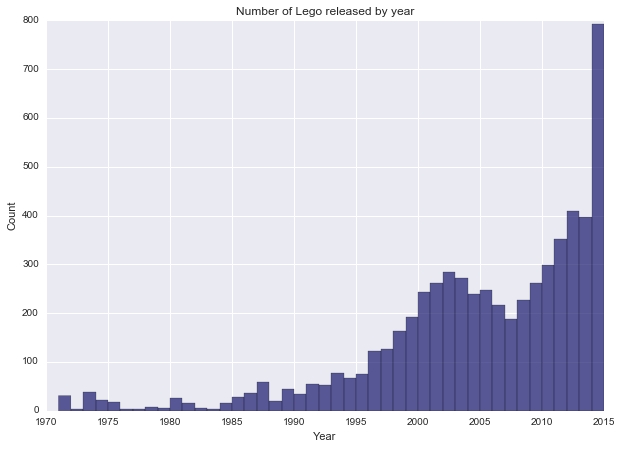

In [46]:
print lego.Year.min()
print lego.Year.max()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Year.hist(color='midnightblue', alpha=.7,ax=ax,bins=np.linspace(lego.Year.min(),lego.Year.max(),lego.Year.max()-lego.Year.min()+1))
ax.set(title='Number of Lego released by year', xlabel='Year', ylabel='Count')
plt.show()

It can be seen that Lego has really rampped up their production through out the years. The most apparent drop in production would be around 2007 and 2008 when the financial crisis hit. It is worth noting that this plot does not show production number directly, it shows the variety of products released that year. However it is very likely for comapnies to expand their business in terms of production and variety in the same time when the economy is good. Therefore it would be a nice reference to look at.

### Themes

In [49]:
len(lego.Theme.value_counts())

115

There are a total of 115 unique themes in the data set. It would be too much to display all of them. Therefore below shows a plot of the top 20 themes. It is worth noting that the top 20 themes have accounted for over 66% of all the data entries.

0.666721826907


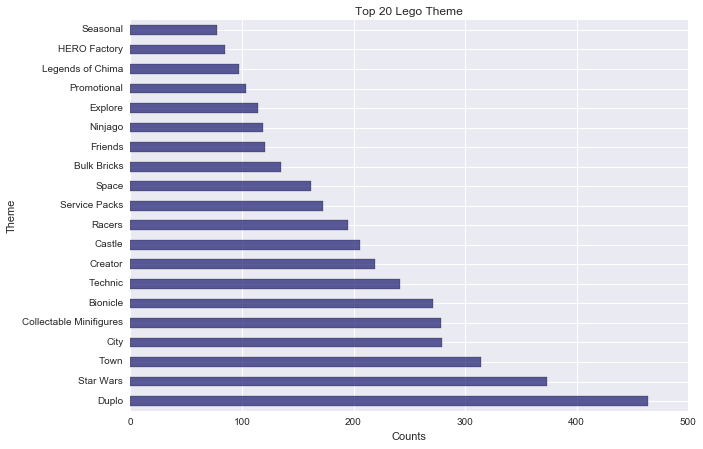

In [88]:
print sum(lego.Theme.value_counts()[:20].values)/len(lego)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Theme.value_counts()[:20].plot(kind='barh', alpha=.7,ax=ax, color='midnightblue')
ax.set(title='Top 20 Lego Theme', xlabel='Counts', ylabel='Theme')
plt.show()

In [69]:
theme_index = lego.Theme.value_counts()[:20].index.tolist()
theme_index = [str(i) for i in theme_index]
theme_pivot = pd.pivot_table(lego, index=['Theme'], values=['Year'], aggfunc=[np.min,np.max])
theme_year = theme_pivot.loc[theme_index]
c = theme_year.amax - theme_year.amin

Having understand which themes have the most number of products, it would be good to see the number of years that the theme was actually in production. This is because naturally if the theme has been in production longer, it is more likely that it would have a higher number of products. If this is the case for every theme, the shape of the "production years" plot would be similar to the above plot.

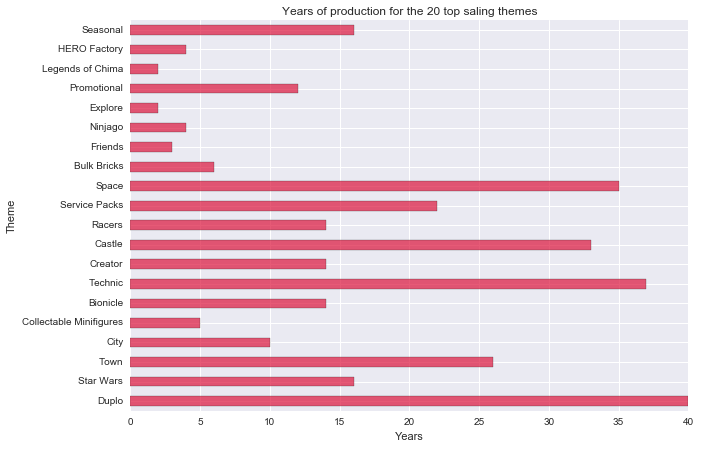

In [95]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
c.plot(kind='barh', alpha=.7,ax=ax, color='crimson')
ax.set(title='Years of production for the 20 top saling themes', xlabel='Years', ylabel='Theme')
ax.legend_.remove()
plt.show()

It is immediately obvious that the shape of the plot is not as expected for every theme. Some themes have existed for long but the number of products are fewer than the other newer lines. For example the Space theme has been around for about 35 years but it has less products comparing to Collectable Minifigures. Duplo however has been the longest lasting theme yet as expected.

### Subthemes

A similar approach can be taken in the analysis of sub themes

In [96]:
len(lego.Subtheme.value_counts())

353

0.172430911799


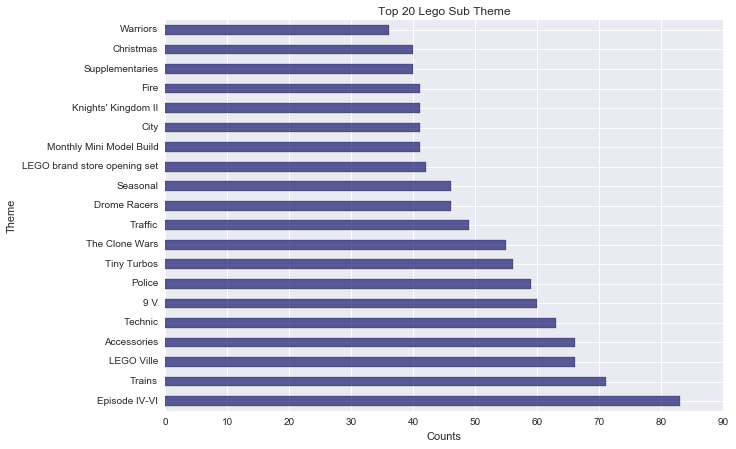

In [101]:
print sum(lego.Subtheme.value_counts()[1:21].values)/len(lego)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Subtheme.value_counts()[1:21].plot(kind='barh', alpha=.7,ax=ax, color='midnightblue')
ax.set(title='Top 20 Lego Sub Theme', xlabel='Counts', ylabel='Theme')
plt.show()

From the above information we know that there are over 300 subthemes and each sub themes has less than 85 entries. Therefore each sub theme accounts for a very small part of the data set. The difference between sub themes are relatively small too. Therefore it is decided that the production years plot is not necessary.

### Pieces

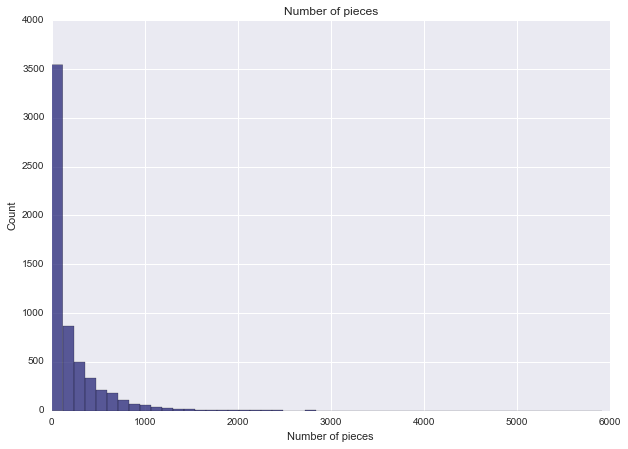

Maximum number of pieces:  5922.0
Minimum number of pieces:  0.0
Median number of pieces:  82.0


In [102]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Pieces.hist(color='midnightblue', alpha=.7,ax=ax, bins=50)
ax.set(title='Number of pieces', xlabel='Number of pieces', ylabel='Count')
plt.show()
print 'Maximum number of pieces: ',lego.Pieces.max()
print 'Minimum number of pieces: ',lego.Pieces.min()
print 'Median number of pieces: ',lego.Pieces.median()

The maximum number of pieces in a set up to year 2015 is 5922 and the minimum is 0. It is not reasonable for a set/item to have 0 pieces so those items would receive further investigations. The shape of the plot clearly demonstrates that the distribution is heavily skewed positively. With a median peice of 83, we know that over half of the data entries have pieces less than 100. In order to investigate deeper, a zoomed in version of the distribution will be plotted with a range of 0 - 500 pieces.

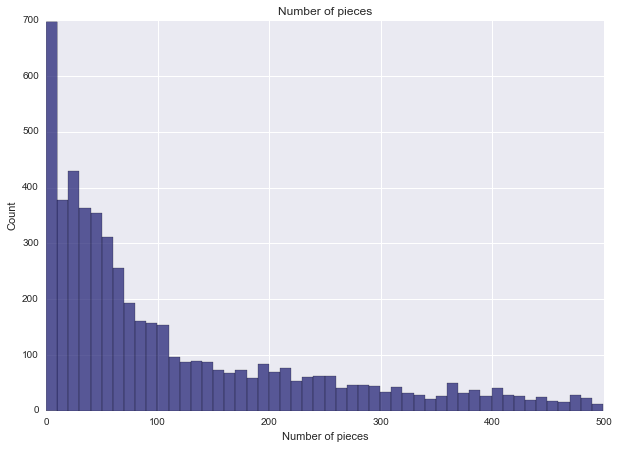

Median number of pieces:  63.0
75 percentile number of pieces:  171.0


In [118]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego[lego.Pieces<500]['Pieces'].hist(color='midnightblue', alpha=.7,ax=ax, bins=50)
ax.set(title='Number of pieces', xlabel='Number of pieces', ylabel='Count')
plt.show()
print 'Median number of pieces: ',lego[lego.Pieces<500]['Pieces'].median()
print '75 percentile number of pieces: ',np.percentile(lego[lego.Pieces<500]['Pieces'],75)

Again we can see that the distribution is still positively skewd. Median value is 63 and 75 percentile lies at 171. It is also realised that starting at about 300 pieces the variations in set counts with number of pieces reduces significantly.

We then move on to the investigation of sets that contains 0 pieces.

In [122]:
lego[lego.Pieces==0]

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id
294,71009,LEGO Minifigures - The Simpsons Series 2 - Com...,2015,Collectable Minifigures,The Simpsons series 2,0.0,16.0,http://images.brickset.com/sets/images/71009-1...,3.99,Foil pack,Retail,311,2598,0,Miscellaneous,0,71009-17
5169,8299,Search Sub,1997,Technic,No_Subtheme,0.0,1.0,http://images.brickset.com/sets/images/8299-1.jpg,50,Box,Retail,271,650,4,Technical,1,8299-1


In [133]:
lego[(lego.Theme=='Collectable Minifigures')&(lego.Pieces<20)]['Pieces'].mean()

6.8125

Item Number 71009 describes a whole set of Lego minifigures. Referencing similar sets such as Item Number 8833 the average number of piece per figure is 7. Therefore the Pieces column will be change to 16 * 7 = 112. Item Number 8299 has 377 pieces where data is obatined from this <a href='https://www.bricklink.com/v2/catalog/catalogitem.page?S=8299-1#T=P'>Bricklink page.</a>

In [135]:
lego.ix[lego.query_id=='71009-17','Pieces'] = 112
lego.ix[lego.query_id=='8299-1','Pieces'] = 377

### Minifigures

Many sets contain minifigures to enhance the Lego experience. Minifigures can come with different bodys, legs and facial expressions. The different combinations add lots of interesting elements in the Lego range. 

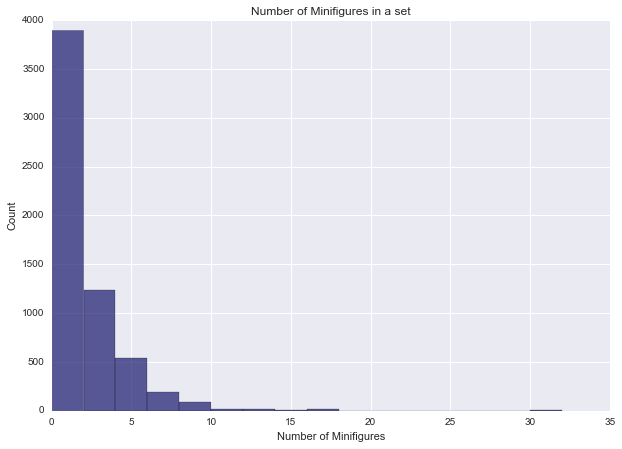

Maximum number of Minifigures:  32.0
Minimum number of Minifigures:  0.0
Median number of Minifigures:  1.0
75 percentile number of Minifigures:  2.0


In [142]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Minifigures.hist(color='midnightblue', alpha=.7,ax=ax, bins=np.linspace(0,32,17))
ax.set(title='Number of Minifigures in a set', xlabel='Number of Minifigures', ylabel='Count')
plt.show()
print 'Maximum number of Minifigures: ',lego.Minifigures.max()
print 'Minimum number of Minifigures: ',lego.Minifigures.min()
print 'Median number of Minifigures: ',lego.Minifigures.median()
print '75 percentile number of Minifigures: ',np.percentile(lego['Minifigures'],75)

Again the plot show positive skewness for number of Minifigures. At least 75% of the sets have less than 2 minifigures. However the maxmium number of Minifugres is 32. This is also possible becuase Lego would sometimes release sets that are focused in minifigures because some collectors focuses their collections on Minifigures.

### MSRP

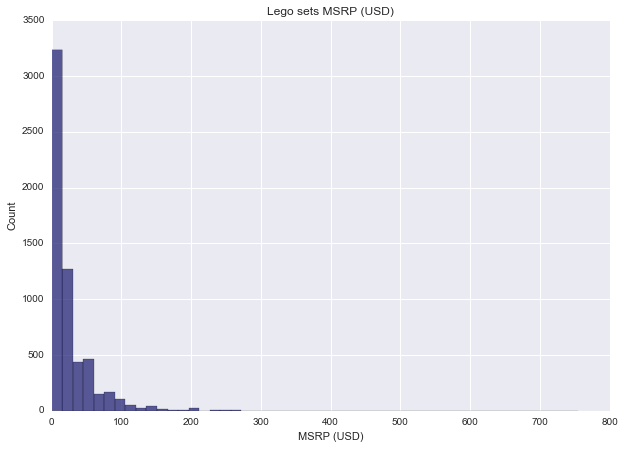

In [146]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.USD_MSRP.astype(float).hist(color='midnightblue', alpha=.7,ax=ax, bins=50)
ax.set(title='Lego sets MSRP (USD)', xlabel='MSRP (USD)', ylabel='Count')
plt.show()

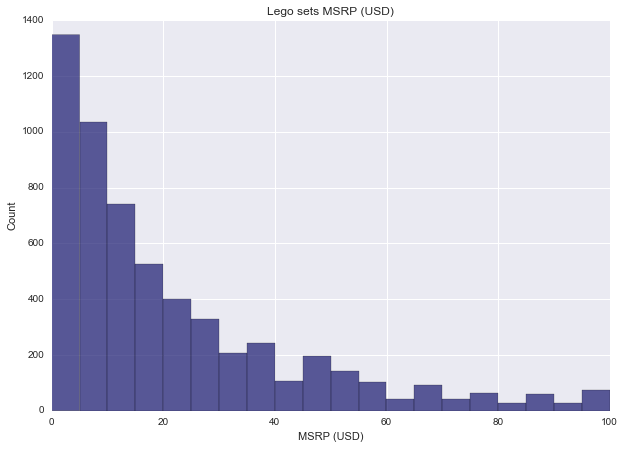

In [200]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.ix[lego.USD_MSRP<100,'USD_MSRP'].astype(float).hist(color='midnightblue', alpha=.7,ax=ax, bins=20)
ax.set(title='Lego sets MSRP (USD)', xlabel='MSRP (USD)', ylabel='Count')
plt.show()

It is realised that most pieces are well below 20 USD. This is rather surprising as we can always see large sets in stores which costs a lot more. However 1 thing to bear in mind is that the prices in the data set has not been adjusted for inflation. Therefore inflation data is obtained from <a href='http://inflationdata.com/Inflation/Inflation_Rate/HistoricalInflation.aspx'>inflationdata.com</a> and adjustments were made.

In [174]:
inflation_lst = np.array([.043,.0327,.0616,.1103,.092,.0575,.065,.0762,.1122,.1358,.1035,.0616,.0322,.043,.0355,.0191,
                 .0366,.0408,.0483,.0539,.0425,.0303,.0296,.0261,.0281,.0293,.0234,.0155,.0219,.0338,.0283,.0159,
                 .0227,.0268,.0339,.0324,.0285,.0385,-0.0034,.0164,.0316,.0207,.0147,.0162])
inf_rev = 1 - inflation_lst
inf = [np.prod(inf_rev[i:]) for i in range(len(inflation_lst))]

[0.14570928634142524,
 0.15225630756679759,
 0.15740339870443251,
 0.16773593212322307,
 0.18853088920222885]

In [194]:
def adj_coef(x):
    if x != 2015:
        diff = x-1971
        return inf[diff]
    return 1
lego['adjust_coef'] = lego['Year'].apply(adj_coef)
lego.USD_MSRP = lego.USD_MSRP.astype(float)
lego['adj_USD_MSRP'] = lego.USD_MSRP/lego.adjust_coef

In [201]:
lego.tail()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id,adjust_coef,adj_USD_MSRP
6055,647,Lorry With Girders,1971,LEGOLAND,Vehicle,52.0,0.0,http://images.brickset.com/sets/images/647-1.jpg,0.6985,Box,Retail,58,130,3,Vintage themes,1,647-1,0.145709,4.793792
6056,648,Service Station,1971,LEGOLAND,Building,55.0,0.0,http://images.brickset.com/sets/images/648-1.jpg,0.6985,Box,Retail,122,236,4,Vintage themes,2,648-1,0.145709,4.793792
6057,795,"2 Large Baseplates, Red/Blue",1971,Basic,Supplementaries,2.0,0.0,http://images.brickset.com/sets/images/795-1.jpg,2.1000,Not specified,Not specified,47,66,0,Basic,0,795-1,0.145709,14.412259
6058,796,"2 Large Baseplates, Green/Yellow",1971,Basic,Supplementaries,2.0,0.0,http://images.brickset.com/sets/images/796-1.jpg,2.1000,Not specified,Not specified,48,62,0,Basic,0,796-1,0.145709,14.412259
6059,798,"2 Medium Baseplates, Green",1971,Basic,Supplementaries,2.0,0.0,http://images.brickset.com/sets/images/798-1.jpg,3.4000,Not specified,Not specified,49,91,0,Basic,0,798-1,0.145709,23.334134


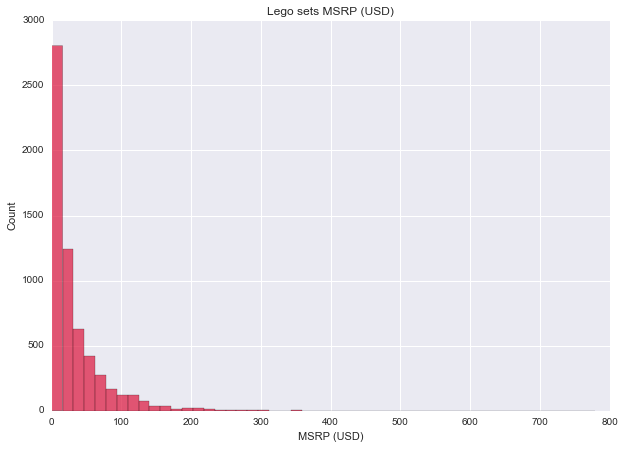

In [202]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.adj_USD_MSRP.astype(float).hist(color='crimson', alpha=.7,ax=ax, bins=50)
ax.set(title='Lego sets MSRP (USD)', xlabel='MSRP (USD)', ylabel='Count')
plt.show()

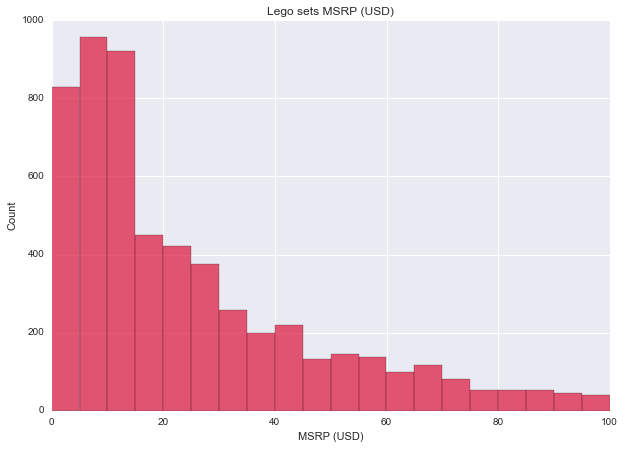

In [204]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.ix[lego.adj_USD_MSRP<100,'adj_USD_MSRP'].astype(float).hist(color='crimson', alpha=.7,ax=ax, bins=20)
ax.set(title='Lego sets MSRP (USD)', xlabel='MSRP (USD)', ylabel='Count')
plt.show()

Although the skewness is still there (which is expected), the distribution is now more 'even'. There are significantly more sets that ranges from 5 USD to 15 USD in terms of ratio.

### Packaging

Most Lego sets are packed as we see them - in boxes. However there are also other packaging methods. Although not as popular as boxes, packaging using plastic bags are also common. Those are called Polybags. Foilbags are used when Lego would like to hide the content in the bag from customers. The most popular example would be the Collectable Minifigure Series. It should also be noted that there are over 1500 instances with no packaging information.

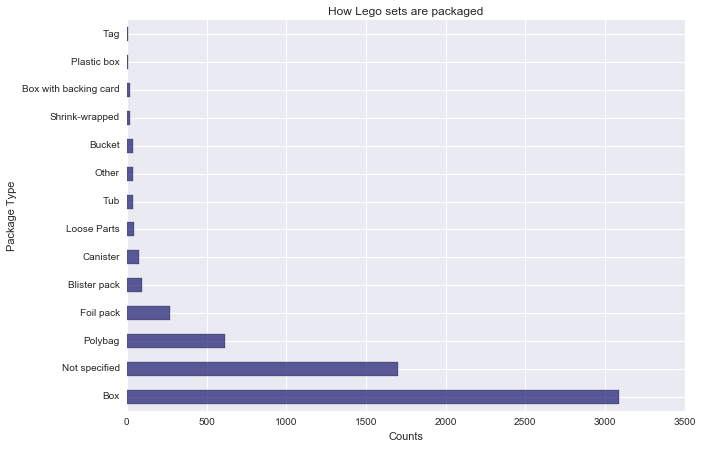

In [206]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Packaging.value_counts().plot(kind='barh', alpha=.7,ax=ax, color='midnightblue')
ax.set(title='How Lego sets are packaged', xlabel='Counts', ylabel='Package Type')
plt.show()

### Availability

Most Lego sets are available for normal retail. However there are also other channels that Lego distributes its products. For example there are Legoland exclusive sets that customers can only purchase in Legoland. There are also limited editions that availability is significantly less than normal products. Similar to the Packaging feature, the availability feature has got over 1500 not-specified instances.

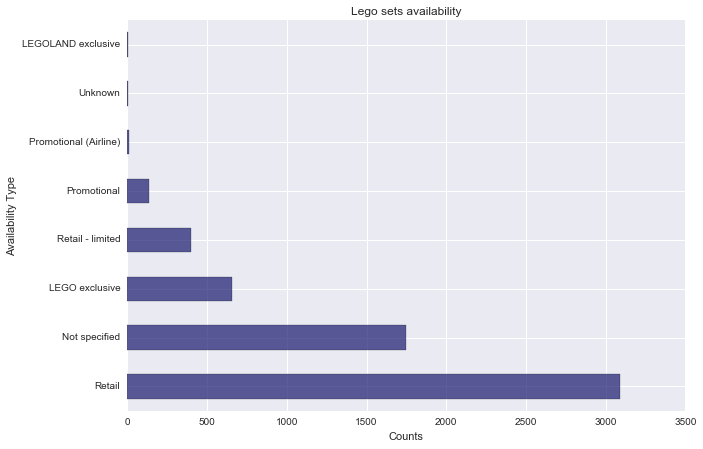

In [208]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.Availability.value_counts().plot(kind='barh', alpha=.7,ax=ax, color='midnightblue')
ax.set(title='Lego sets availability', xlabel='Counts', ylabel='Availability Type')
plt.show()

### Wanted and Owned

In the website Brickset.com, registered users are able to indicate their interest in specific Lego sets by saying that they want it. They can also record the ownership of their own Lego sets. Therefore for the same Lego item number, there are two figures showing the 'want' and 'own' respectively. The following plots demonstrate the distribution of such figures.

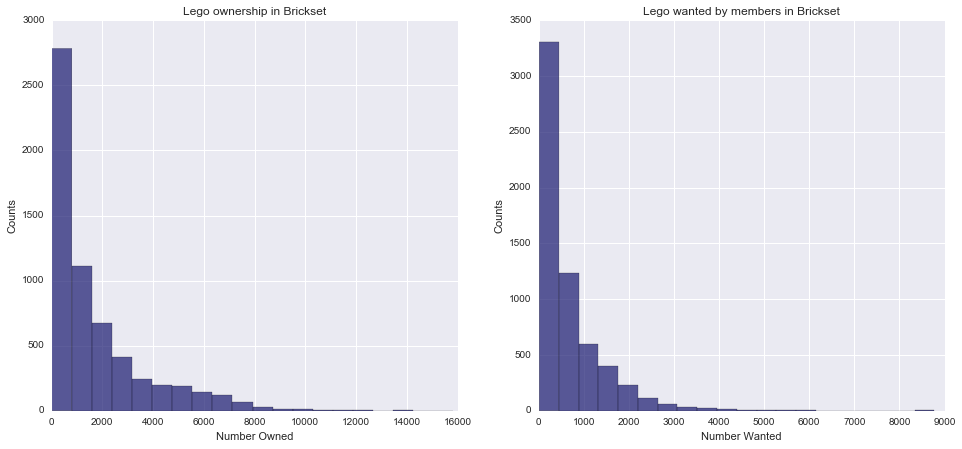

In [220]:
lego.wanted = lego.wanted.astype(float)
lego.owned = lego.owned.astype(float)
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
lego.owned.hist(color='midnightblue', alpha=.7,ax=ax1, bins=20)
ax1.set(title='Lego ownership in Brickset', xlabel='Number Owned', ylabel='Counts')
lego.wanted.hist(color='midnightblue', alpha=.7,ax=ax2, bins=20)
ax2.set(title='Lego wanted by members in Brickset', xlabel='Number Wanted', ylabel='Counts')
plt.show()

From the plots above it can be seen that the distributions (in terms of shape) are very similar. Most pieces have very little votes. This could be due to the fact that not many sets are high profile sets and the majority receives very little attention. Therefore their votes on either categories are relatively low.

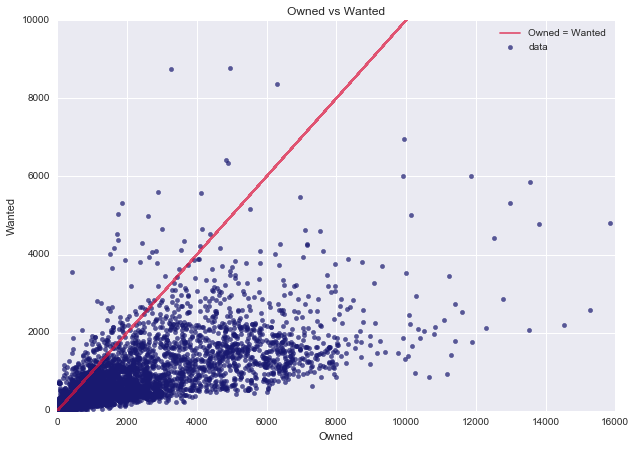

In [237]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.scatter(lego.owned,lego.wanted, color='midnightblue', alpha=.7, label='data')
ax1.plot(lego.owned,lego.owned, color='crimson', alpha=.7, label = 'Owned = Wanted')
ax1.set(title='Owned vs Wanted', xlabel='Owned', ylabel='Wanted',xlim=[0,16000],ylim=[0,10000])
plt.legend()
plt.show()

The above scatter plot describes the relationship between the 'wants' and 'owns' for various Lego sets. In order to assist the interpretation of the plot, a line showing want = own is also plotted. As expected we can see from the graph that most data points fall under the line. This means that most sets have more owns than wants. This is very common as the simple economic theory suggest that the rarer an items is the less supply it has; which in turns leads to a small number of total owners. The top 3 wanted sets are shown below:

In [3]:
lego[lego.wanted>8000]

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id,adjust_coef,adj_USD_MSRP
2514,10185,Green Grocer,2008,Advanced Models,Modular Buildings,2352.0,4.0,http://images.brickset.com/sets/images/10185-1...,149.99,Box,Retail - limited,8373.0,6304.0,4.89655172413793,Model making,29,10185-1,0.872344,171.939066
2740,10179,Ultimate Collector's Millennium Falcon,2007,Star Wars,Ultimate Collector Series,5195.0,5.0,http://images.brickset.com/sets/images/10179-1...,499.99,Not specified,Not specified,8763.0,3267.0,4.76190476190476,Licensed,21,10179-1,0.847482,589.971146
2742,10182,Cafe Corner,2007,Advanced Models,Modular Buildings,2056.0,3.0,http://images.brickset.com/sets/images/10182-1...,139.99,Box,LEGO exclusive,8774.0,4953.0,4.76470588235294,Model making,34,10182-1,0.847482,165.183425


### More on the definition of classification labels

As we can tell from the data set that there are no obvious labels to differentiate common sets from desirable sets, it is important to discuss how 'desirable-ness' should be measured. In the following summary the considered metrics would be proposed and its relevant pros and cons will be discussed.

- Using the 'Wanted' number:
This is the most straight forward metric that one can derived at. The biggest advantage in using this metric is that it is simple and easy to understand. The disadvantage of simply using 'wanted' is that it might not capture some information that is more complicated such as the number of people wanting a specific set. In other words if many people want a certain set but in the same time even more people own it. Does that still make the set desirable/collectable?


- Using $Wanted/Owned$:
Addressing the problem discussed above, one can use another label metric (denoted l): $$l = \frac{Wanted}{Owned}$$This metric takes into account of set ownership as well. That is if a highly wanted set is also owned by many, l would not be high. This can in a way more accurately reflect the rarity of a Lego set. However this leads to another potential problem. The same 'l' can be achieved by different combinations of wanteds and owneds. For example having a 'l' metric of 3, there could be 3000 wanted and 1000 owned for set A and 3 wanted and 1 owned for set B. Common sense tells us that set A and set B are probably not equally desirable. Since set B receives less 'votes' in each category it might just means that set B is not very popular so hobbyist do not bother expressing their interest/ownership. This effect is not reflected in this 'l' metric.

- Incorpration of certain 'distance' components:
One way to mitigate the problem mentioned above is to include a distance component in the 'l' metric. There are two major ways that this could be achieved. The first one is to include a component in proportion to the data point's distance from the origin (point 0,0). This distance can effectively reflect the popularity of a data point. The greater the distance, the more vote a set has. This is because such distance is the square root of 'owned' squared + 'wanted' squared. 

Another distance component is the normal distance from the line wanted = owned. Since the data points can not have negative values, this distance is inheritedly small when it is near the origin. 

However it is tricky to incorprate these distance components in the 'l' metric. It is difficult to properly quantify their weighting and their effect on the metric. It is also more difficult for audiences to comprehend this metric.

#### Colnclusion

From the discussion above we know that there are advantages in itroducing a more complex lable to the dataset. However it is difficult to incorporate the metric properly. This is due to the fact that it is not poosible to easily integrate the distance component nor is the explantion to target audiences. Therefore for now the 'wanted' column wills serve as the 'desirable-ness' label with the top 10% defined as 'desirable'. However other labeling methods will also be investigated and improvement in this labeling system can take place

### Ratings

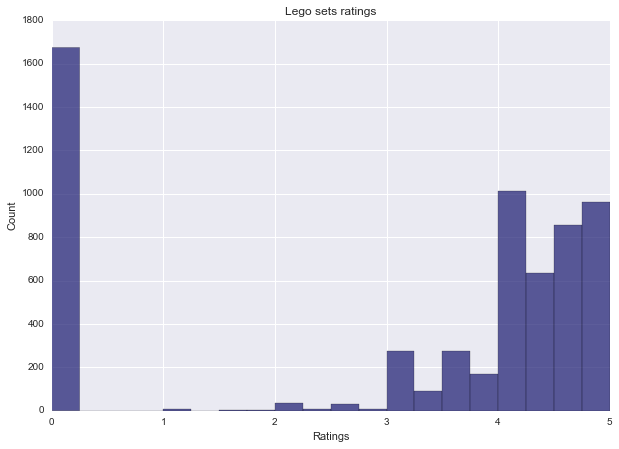

In [6]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.rating.astype(float).hist(color='midnightblue', alpha=.7,ax=ax, bins=20)
ax.set(title='Lego sets ratings', xlabel='Ratings', ylabel='Count')
plt.show()

The shape of the rating distribution is rather unexpected. It can be seen that the ratings are concentrated in either end of the plot. It is suspected that most of the 0 rated items are actually items without ratings and the values were filled in during the data cleaning process. At the other end of the spectrum lies the review of the users. It is common for hoobyist to give reviews to those sets that they like but not to criticise the sets that are average. This could be the reason leading to this extreme situation.

### Theme Group

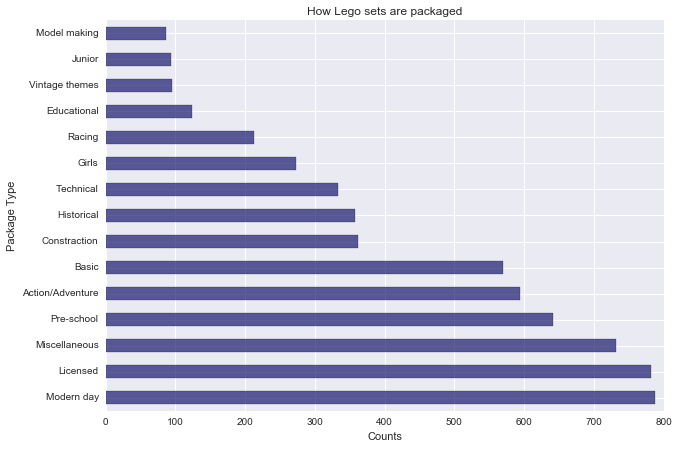

In [7]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.theme_grp.value_counts().plot(kind='barh', alpha=.7,ax=ax, color='midnightblue')
ax.set(title='How Lego sets are packaged', xlabel='Counts', ylabel='Package Type')
plt.show()

Theme group is just like "Theme" or "Subtheme" where sets are categorised. However theme group has less overall categories which allows users to compare better.

### Number of reviews

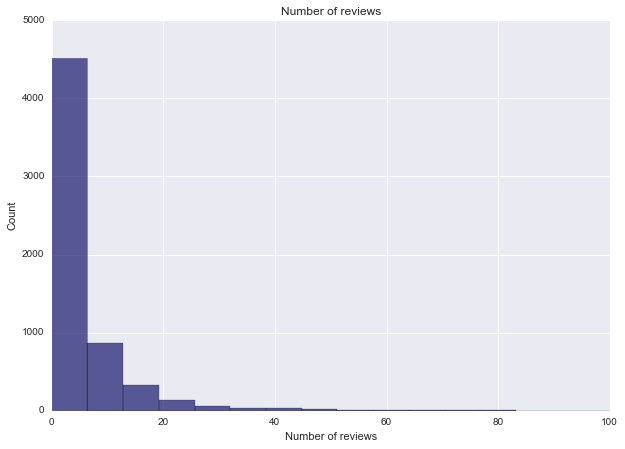

Maximum reviews:  97
Minimum reviews:  0
Median:  2.0


In [11]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
lego.review_num.astype(float).hist(color='midnightblue', alpha=.7,ax=ax, bins=20)
ax.set(title='Number of reviews', xlabel='Number of reviews', ylabel='Count',xlim=[0,100])
plt.show()
print 'Maximum reviews: ',lego.review_num.max()
print 'Minimum reviews: ',lego.review_num.min()
print 'Median: ',lego.review_num.median()

Again it shows that most sets have very small number of reviews which is less than or equal to 2. It is suspected that because most hobbyist would like to reviews sets that are special or popular - which accounts for a very small number of the total available data.

### Others

#### Effect of inflation adjustment on prices

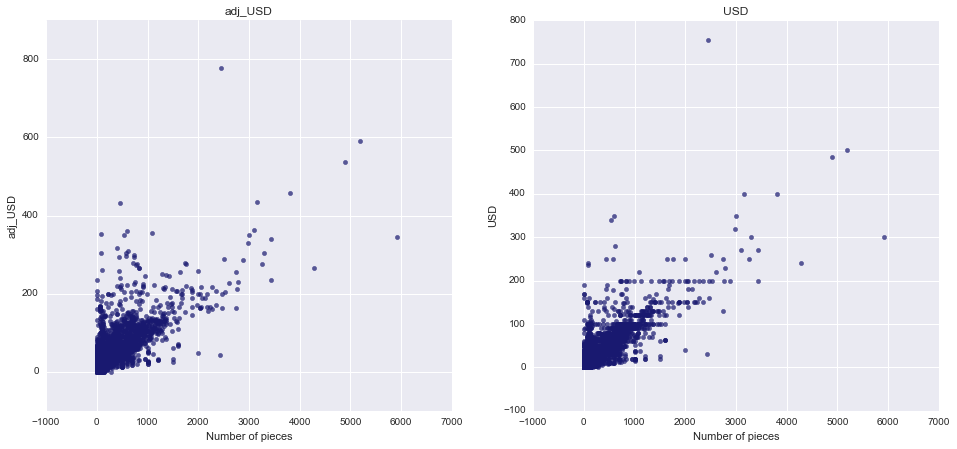

In [13]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(lego.Pieces,lego.adj_USD_MSRP, color='midnightblue', alpha=.7)
ax1.set(title='adj_USD', xlabel='Number of pieces', ylabel='adj_USD')
ax2.scatter(lego.Pieces,lego.USD_MSRP, color='midnightblue', alpha=.7)
ax2.set(title='USD', xlabel='Number of pieces', ylabel='USD')
plt.show()

The above plots show the effect of inflation adjustment. Although the distribution shape stays rather similar, some patterns or evidence or thresholds disappear which were shown as horizontal lines in the non-adjusted plot.

#### Price per pieces

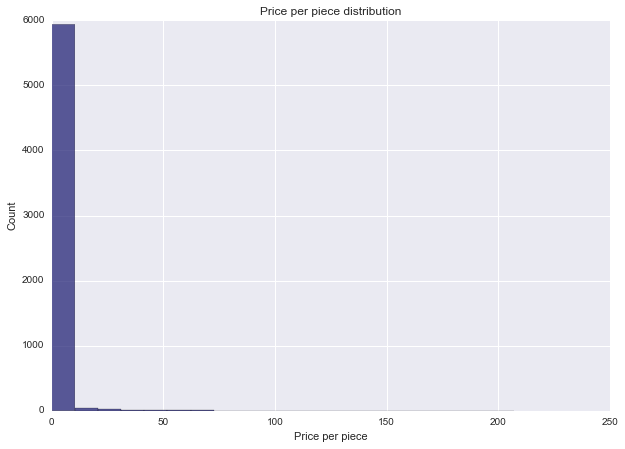

Max price per piece:  207.29888571
Min price per piece:  0.0
Median:  0.171614817352
75 percentile:  0.370455367834


In [4]:
ppp = lego.adj_USD_MSRP/lego.Pieces
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ppp.hist(color='midnightblue', alpha=.7,ax=ax, bins=20)
ax.set(title='Price per piece distribution', xlabel='Price per piece', ylabel='Count')
plt.show()
print 'Max price per piece: ',ppp.max()
print 'Min price per piece: ',ppp.min()
print 'Median: ',ppp.median()
print '75 percentile: ',np.percentile(ppp,75)

From the above plot it can be seen that the price per pieces figures are mostly under 0.4. However some sets have a figure as high as over 200. In order to understand what is going on there a futher investigation was carried out.

In [7]:
lego['Price_per_piece'] = lego.adj_USD_MSRP/lego.Pieces
lego[lego.Price_per_piece>50].head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id,adjust_coef,adj_USD_MSRP,Price_per_piece
959,45500,EV3 Intelligent Brick,2013,Mindstorms,EV3,1.0,0.0,http://images.brickset.com/sets/images/45500-1...,189.99,Not specified,LEGO exclusive,112.0,47.0,0,Technical,0,45500-1,0.969338,195.999716,195.999716
1613,10285,Compass Sensor,2011,Mindstorms,NXT,1.0,0.0,http://images.brickset.com/sets/images/10285-1...,54.99,Not specified,Not specified,124.0,62.0,3,Technical,1,10285-1,0.919276,59.818826,59.818826
1614,10286,Colour Sensor,2011,Mindstorms,NXT,1.0,0.0,http://images.brickset.com/sets/images/10286-1...,54.99,Not specified,Not specified,98.0,48.0,0,Technical,0,10286-1,0.919276,59.818826,59.818826
1676,2852724,Accelerometer Sensor,2011,Mindstorms,NXT,1.0,0.0,http://images.brickset.com/sets/images/2852724...,54.99,Not specified,Not specified,123.0,53.0,5,Technical,1,2852724-1,0.919276,59.818826,59.818826
1677,2852725,Infrared Seeker,2011,Mindstorms,NXT,1.0,0.0,http://images.brickset.com/sets/images/2852725...,49.99,Not specified,Not specified,107.0,33.0,0,Technical,0,2852725-1,0.919276,54.379762,54.379762


By looking at the table above we can conclude that the high 'price per piece' cases comes from mostly the Mindstorms theme. Mindstorms is a series of components made by Lego to allow users build complex mechanism. It is very widely used in robotics as we can see there are various sensors and transducers included. Due to the complexity the price of each piece would naturally be very high. Other unusually high priced pieces includes a play wall in the Duplo series which is like a table where you can build Lego on top.

## set_pieces EDA

The Set_pieces contains data that relates individual pieces to various lego sets

In [4]:
set_pieces = pd.read_sql('SELECT * FROM set_pieces', engine)
set_pieces.head()

,set_id,piece_id,num,color,type
0,00-1,29c01,8,4,1
1,00-1,29c01,6,15,1
2,00-1,3001a,4,1,1
3,00-1,3001a,9,4,1
4,00-1,3001a,25,15,1


#### Number of uniques pieces

As color is recorded in as a seperate feature, the feature piece_id records the design and shape of a certain piece only. From the analysis there are more than 23615 unique shapes in this data set.

In [9]:
len(set_pieces['piece_id'].value_counts())

23615

#### Number of uniques colours

Similar to the above analysis, it is discovered that there are 131 unique colours

In [10]:
len(set_pieces['color'].value_counts())

131

#### Number of types

There are 2 types of parts. The majority of the are type 1. This is beacause type 1 indicates normal parts and type 2 indicates spare parts 

In [12]:
set_pieces['type'].value_counts()

1    521195
2     25961
Name: type, dtype: int64

In [20]:
from pandas.io import sql
engine = create_engine('postgresql://localhost/capstone')
conn = engine.connect()
sql.read_sql('''SELECT piece_id, SUM(num) AS count FROM set_pieces
             GROUP BY piece_id
             ORDER BY count DESC LIMIT 5;''', con=conn)

,piece_id,count
0,3004,67743.0
1,3023,55164.0
2,6141,49874.0
3,3003,47561.0
4,3005,45749.0


In [25]:
sql.read_sql("""
SELECT
    piece_id || '_' || color AS piece_color,
    SUM(num) AS sum_num
FROM set_pieces
GROUP BY piece_color
ORDER BY sum_num ASC
LIMIT 5
""", con=conn).head()

,piece_color,sum_num
0,00-3_89,1.0
1,00-4_89,1.0
2,0687b1_9999,1.0
3,0901_2,1.0
4,00-2_89,1.0


## Pieces EDA

In [15]:
pieces = pd.read_sql('SELECT * FROM pieces', engine)
pieces.head()

,piece_id,descr,category
0,15068,Slope Curved 2 x 2 x 2/3,Bricks Curved
1,3665,Slope Inverted 45° 2 x 1,Bricks Sloped
2,60131stk01,Sticker for Set 60131 - (24555/6133223),Non-LEGO
3,99460,"BANDAGE 4,5x20",Other
4,98192,FEEDING RACK,Other


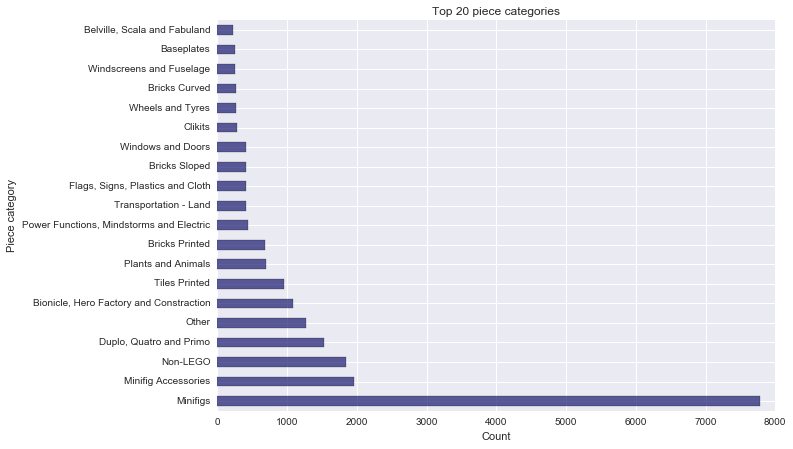

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
pieces.category.value_counts()[:20].plot(kind='barh', figsize=(10,7),color='midnightblue',alpha=.7,ax=ax)
ax.set(xlabel='Count', ylabel='Piece category', title='Top 20 piece categories')
plt.show()

The parts categoreis are shown in the plot above. It can be seen that Minifig accoutns for most of the varieties. This could be due to the fact that larger builds require the combinations of many standard parts. However as Minifigures are usually unique (in terms of design and printing on the body, legs and heads), it is expected that they have a lot of varieties.

## Data dictionary

A data dictionary is created in order to easily identify and naviagate between data sets.

In [ ]:
data = {'lego':lego,
        'set_pieces':set_pieces,
        'pieces':pieces}

Save the cleaned data set to the PostgreSQL database

In [238]:
lego.to_sql('lego_cleaned_temp',engine,index=False)

In [5]:
len(set_pieces.piece_id.value_counts())

23615

In [8]:
set_pieces['piece_color'] = set_pieces.piece_id + '_' + set_pieces.color.astype(str)

In [13]:
piece_color = pd.get_dummies(set_pieces.piece_color)

In [ ]:
for i in range(len(set_pieces)):
    target = set_pieces.ix[i,'piece_color']
    piece_color.ix[i,target] = set_pieces.ix[i,'num']

In [9]:
piece_color = set_pieces.piece_color.unique()
set_id = set_pieces.set_id.unique()

In [10]:
set_pieces_df = pd.DataFrame(np.nan, index=set_id, columns=piece_color)
set_pieces_df.head(3)

,29c01_4,29c01_15,3001a_1,3001a_4,3001a_15,3002a_4,3002a_15,3003_1,3003_14,3003_15,...,6564-1_-1,7130-1_-1,7150-1_-1,973pr1184c01_272,973pb1144c01_25,973pb1145c01_15,973pb1146c01_71,6712-1_-1,6716-1_-1,6755-1_-1
00-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
for i in range(len(set_pieces)):
    tar_set = set_pieces.ix[i,'set_id']
    tar_pc = set_pieces.ix[i,'piece_color']
    set_pieces_df.loc[tar_set,tar_pc] = set_pieces.ix[i,'num']

In [12]:
set_pieces_df.loc['00-1','29c01_4']

nan

In [20]:
set_pieces_df = set_pieces_df.fillna(0)

In [21]:
set_pieces_df.to_csv('set_pieces_transformed.csv',index=False)

In [22]:
set_pieces_df.head()

,29c01_4,29c01_15,3001a_1,3001a_4,3001a_15,3002a_4,3002a_15,3003_1,3003_14,3003_15,...,6564-1_-1,7130-1_-1,7150-1_-1,973pr1184c01_272,973pb1144c01_25,973pb1145c01_15,973pb1146c01_71,6712-1_-1,6716-1_-1,6755-1_-1
00-1,8.0,6.0,4.0,9.0,25.0,6.0,16.0,3.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0012-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0013-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
